 # Traffic Sign Recognition Classifier with Conv Net
 Training and testing CNN model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [1]:
from IPython import get_ipython
from glob import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import pandas as pd


 ## Load The Data

In [2]:
# Load pickled data
training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


 ## Dataset Summary & Exploration

 The pickled data is a dictionary with 4 key/value pairs:

 - `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
 - `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
 - `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
 - `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


 ### Exploratory visualization of the dataset

In [4]:
sign_names = pd.read_csv('signnames.csv', delimiter=',')
sign_names_dict = sign_names.to_dict()['SignName']
def signName(label):
    return '{}-{}'.format(label, sign_names_dict[label])

def signNames(labels):
    return list(map(lambda l: signName(l), labels))

41-End of no passing


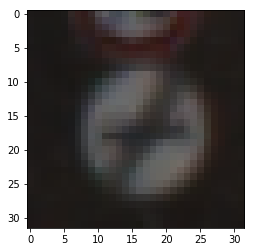

In [5]:

get_ipython().run_line_magic('matplotlib', 'inline')

plt.imshow(X_train[0])
print(signName(y_train[0]))


3-Speed limit (60km/h)


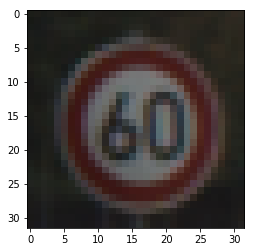

In [6]:
# Show random image from a train set
index = np.random.randint(0, len(X_train))
plt.imshow(X_train[index])
print(signName(y_train[index]))


 ## Model Architecture

 ### Pre-processing the Data Set (normalization)

In [7]:
# Preprocessing data
def preprocess(x):
    return (x.astype(np.float32) - 128) / 128
X_train_processed = preprocess(X_train)
X_valid_processed = preprocess(X_valid)
X_test_processsed = preprocess(X_test)


In [8]:
print('Sanity check for preprocessing step...')
print('Max value in preprocessed train data {}'.format(np.max(X_train_processed)))
print('Min value in preprocessed train data {}'.format(np.min(X_train_processed)))


Sanity check for preprocessing step...
Max value in preprocessed train data 0.9921875
Min value in preprocessed train data -1.0


 ### Net Architecture

In [9]:

def conv2d(x, W, b, strides=1):
    conv = tf.nn.conv2d(x, W, strides=[1,strides,strides,1], padding='VALID')
    conv = tf.nn.bias_add(conv, b)
    return tf.nn.relu(conv)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

EPOCHS = 10
BATCH_SIZE = 128

dropout_keep_prob = tf.placeholder(tf.float32)
conv_dropout_keep_prob = tf.placeholder(tf.float32)

conv1 = None
def ConvNet(x):
    global conv1

    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    wc1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mu, sigma))
    bc1 = tf.Variable(tf.truncated_normal([6], mu, sigma))
    conv1 = conv2d(x, wc1, bc1, strides=1)

    # Pooling. Input = 28x28x6. Output = 14x14x6
    conv1 = maxpool2d(conv1, k=2)
    conv1 = tf.nn.dropout(conv1, keep_prob=conv_dropout_keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    wc2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma))
    bc2 = tf.Variable(tf.truncated_normal([16], mu, sigma))
    conv2 = conv2d(conv1, wc2, bc2, strides=1)

    # Pooling. Input = 10x10x16. Output = 5x5x16
    conv2 = maxpool2d(conv2, k=2)
    conv2 = tf.nn.dropout(conv2, keep_prob=conv_dropout_keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    conv2Flat = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    wd1 = tf.Variable(tf.truncated_normal([400, 120], mu, sigma))
    bd1 = tf.Variable(tf.truncated_normal([120], mu, sigma))
    fc1 = tf.add(tf.matmul(conv2Flat, wd1), bd1)

    # ReLU Activation
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob=dropout_keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    wd2 = tf.Variable(tf.truncated_normal([120, 84], mu, sigma))
    bd2 = tf.Variable(tf.truncated_normal([84], mu, sigma))
    fc2 = tf.add(tf.matmul(fc1, wd2), bd2)
    
    # ReLU Activation
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob=dropout_keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes
    wOut = tf.Variable(tf.truncated_normal([84, n_classes], mu, sigma))
    bOut = tf.Variable(tf.truncated_normal([n_classes], mu, sigma))
    logits = tf.add(tf.matmul(fc2, wOut), bOut)
    
    return logits



In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001

logits = ConvNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss)

### Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    sess = tf.get_default_session()
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        maxI = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:maxI], y_data[offset:maxI]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: 1, conv_dropout_keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()


 ## Train, Validate and Test the Model

## Model Training

In [12]:
tf.set_random_seed(123456)
model_save_file = './model/model.ckpt'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    num_examples = len(X_train_processed)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_shuffled, y_shuffled = shuffle(X_train_processed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_shuffled[offset:offset+BATCH_SIZE], y_shuffled[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: 0.75, conv_dropout_keep_prob: 0.9})
        
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {}: Validation accuracy {:.3f}".format(i+1, validation_accuracy))

    saver.save(sess, model_save_file)
    print("Model saved")


Training...

EPOCH 1: Validation accuracy 0.740
EPOCH 2: Validation accuracy 0.871
EPOCH 3: Validation accuracy 0.897
EPOCH 4: Validation accuracy 0.920
EPOCH 5: Validation accuracy 0.927
EPOCH 6: Validation accuracy 0.932
EPOCH 7: Validation accuracy 0.929
EPOCH 8: Validation accuracy 0.935
EPOCH 9: Validation accuracy 0.933
EPOCH 10: Validation accuracy 0.937
Model saved


 ### Validation Accuracy

In [13]:
with tf.Session() as sess:
    saver.restore(sess, model_save_file)

    test_accuracy = evaluate(X_valid_processed, y_valid)
    print("Validation Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Validation Accuracy = 0.937


 ### Test Accuracy

In [14]:
with tf.Session() as sess:
    saver.restore(sess, model_save_file)

    test_accuracy = evaluate(X_test_processsed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Test Accuracy = 0.934


 ## Test a Model on New Images (out of this data set)

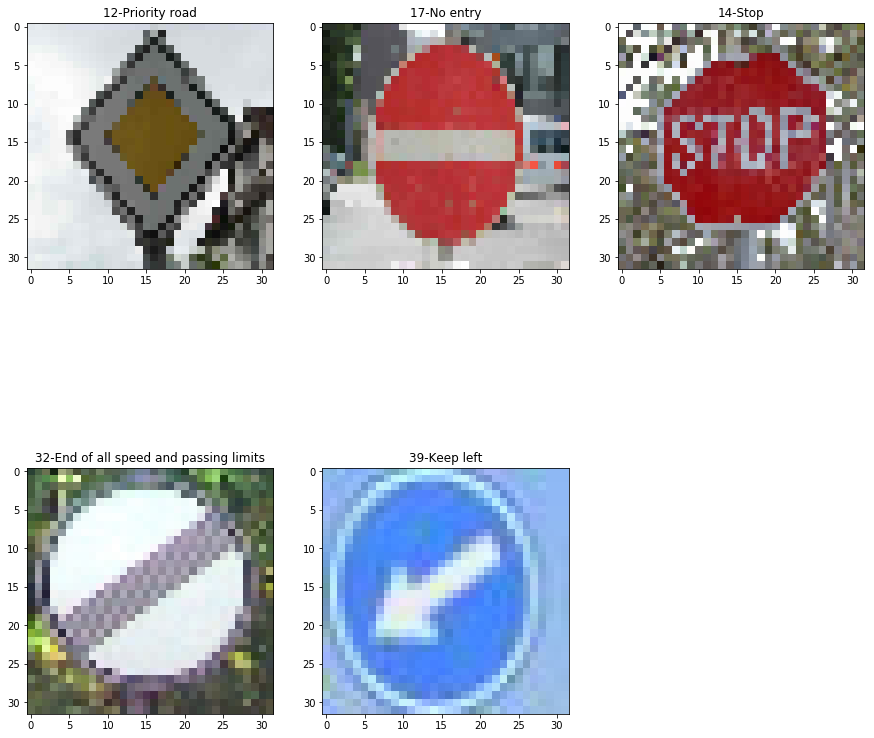

In [15]:

filenames = glob('./images/*')
test_imgs = []
test_labels = []
plt.figure(1, figsize=(15,15))
for i in range(len(filenames)):
    img = mpimg.imread(filenames[i])
    img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_LINEAR)
    test_imgs.append(img)
    label = int(filenames[i].split('/')[-1].split('_')[0])
    test_labels.append(label)
    # plot
    plt.subplot(2,3,i+1)
    plt.title(signName(label))
    plt.imshow(img)


 ### Predict the Sign Type for Each Image

In [16]:

test_imgs_processed = preprocess(np.array(test_imgs))
with tf.Session() as sess:
    saver.restore(sess, model_save_file)

    accuracy_test_imgs = evaluate(test_imgs_processed, test_labels)
    print("Accuracy = {:.2f}%".format(accuracy_test_imgs*100))
    print("======================")
    print("======================")

    softmax = tf.nn.softmax(logits)
    top5_softmax_eval = sess.run(tf.nn.top_k(softmax, k=5), feed_dict={x: test_imgs_processed, y: test_labels, dropout_keep_prob: 1., conv_dropout_keep_prob: 1.0})
    print(top5_softmax_eval)

predictions = top5_softmax_eval.indices[:,0]
print("LABELS")
print(signNames(test_labels))
print("======================")
print("PREDICTIONS")
print(signNames(predictions))


INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Accuracy = 80.00%
TopKV2(values=array([[  9.99999285e-01,   5.62274238e-07,   1.43300710e-07,
          2.68826081e-08,   5.70245406e-09],
       [  9.99999881e-01,   1.18732004e-07,   1.61691313e-10,
          3.01636776e-15,   2.44037286e-15],
       [  9.99989867e-01,   1.01667583e-05,   1.57128963e-10,
          8.94807284e-11,   8.13515436e-11],
       [  7.02284217e-01,   2.52887905e-01,   3.13098356e-02,
          7.01447157e-03,   3.96878738e-03],
       [  9.98746514e-01,   8.97076796e-04,   3.56017379e-04,
          3.08600079e-07,   1.86164488e-08]], dtype=float32), indices=array([[12, 13, 32, 38, 17],
       [17, 14, 29,  0, 26],
       [14, 17,  5, 13, 29],
       [41, 32, 38, 12, 42],
       [39, 33, 37, 40,  8]], dtype=int32))
LABELS
['12-Priority road', '17-No entry', '14-Stop', '32-End of all speed and passing limits', '39-Keep left']
PREDICTIONS
['12-Priority road', '17-No entry', '14-Stop', '41-End of no pa

 ### Top 5 Softmax Predictions per Image

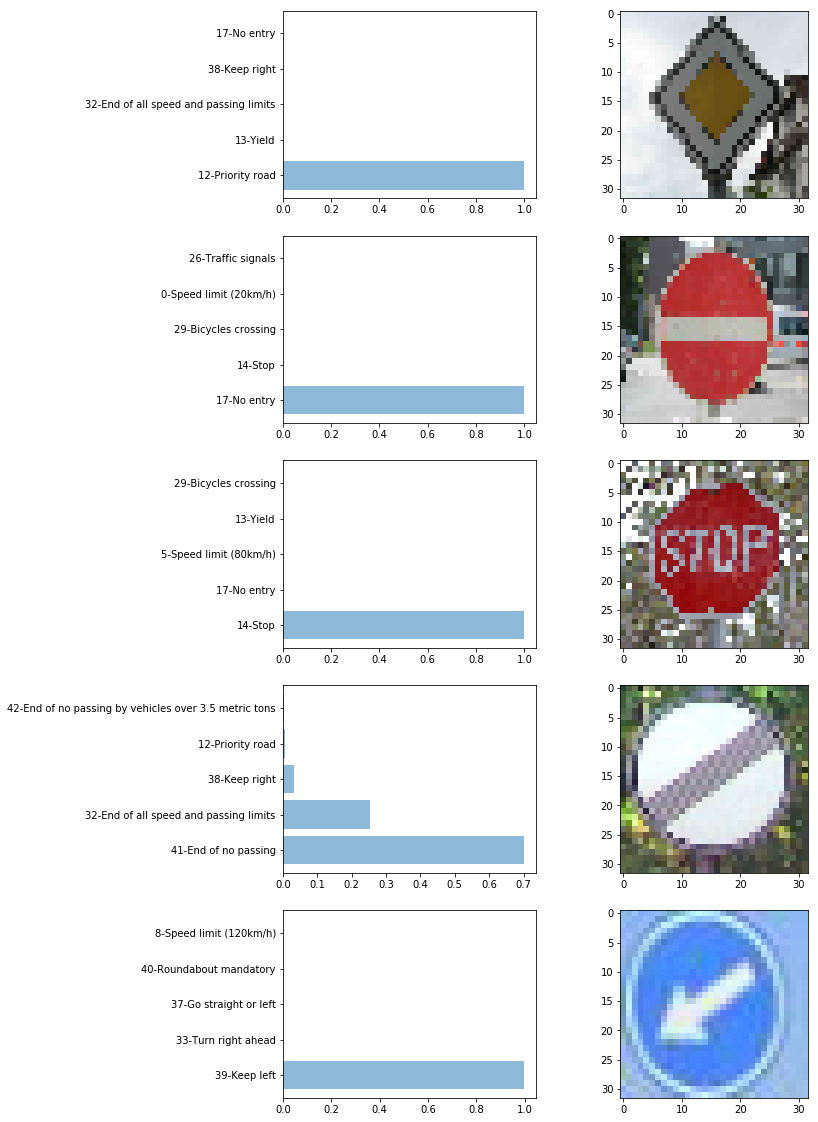

In [17]:

softmax_labels_named = list(map(lambda x: signNames(x), top5_softmax_eval.indices))
plt.figure(figsize=(10,20))
for i in range(len(softmax_labels_named)):
    plt.subplot(5,2,i*2+1)
    y_pos = np.arange(len(softmax_labels_named[i]))
    plt.barh(y_pos, top5_softmax_eval.values[i], align='center', alpha=0.5)
    plt.yticks(y_pos, softmax_labels_named[i])
    plt.subplot(5,2,i*2+2)
    plt.imshow(test_imgs[i])
plt.show()


 ## Visualizing the Neural Network's State with Test Images

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
(1, 14, 14, 6)


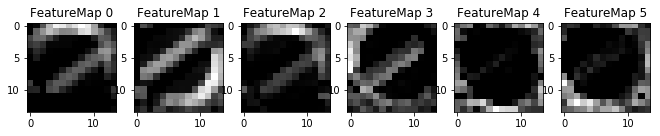

In [19]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, dropout_keep_prob: 1., conv_dropout_keep_prob: 1.})
    print(activation.shape)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, model_save_file)
    outputFeatureMap([test_imgs_processed[3]], conv1)